In [2]:
!pip install xgboost 

In [3]:
import numpy as np 
import pandas as pd 
import xgboost as xg 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE 

In [4]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


# Getting dataset and clean sample with NaN in Grain.As

```dataset``` for full dataset : 692 sample

```cleaned_dataset``` for cleaned dataset (removed samples with null Asen values) : 669 samples

In [5]:
# Load the dataset
dataset = pd.read_excel(r'D:\project\Asen_Accumulation\data\16-Aviric.xlsx')

# Drop rows where 'Grain_As' column has missing values
cleaned_dataset = dataset.dropna(subset=['Grain.As'])

In [6]:
# Check the cleaned dataset
print(f"Original dataset shape: {dataset.shape}")
print(f"Cleaned dataset shape: {cleaned_dataset.shape}")
print(cleaned_dataset.head())

Original dataset shape: (693, 29)
Cleaned dataset shape: (669, 29)
  Sample.code  Lattitude    Longitude        Season.planted  Grain.As  \
0   23Vin1_#1   10.105651  105.894707  Winter-Spring season  0.523334   
1   23Vin2_#1   10.071678  105.927982  Winter-Spring season  0.312485   
2   23Vin3_#1   10.073358  105.992213  Winter-Spring season  0.058160   
3   23Vin4_#1   10.142449  106.021702  Winter-Spring season  0.037008   
4   23Vin5_#1   10.075267  106.170488  Winter-Spring season  0.170522   

       Grain.P      Grain.S   Grain.Mn   Grain.Fe  Grain.Cu  ...   Soil.S  \
0  2984.341641  1092.869532  22.782137  28.896448  2.074383  ...  1161.03   
1  3127.027761  1131.268467  19.842637   1.784861  2.024729  ...  1664.97   
2  3195.274467   991.132283  17.984741  41.951877  1.626614  ...   803.94   
3  2682.304757   855.024208  16.678840   1.100623  1.760309  ...  2331.02   
4  2963.072168   810.699618  15.986882   3.180604  0.975245  ...   458.27   

   Soil.Mn   Soil.Fe  Soil.pH  

# Writing functions to make experiments 

```training``` : for training

- geting parameter ```dataset``` , ```params``` for XGboost , ```num_boost_round``` , ```seed``` 
 
- ```training``` return: ```model``` after trained ,  training result ```evals_result``` , ```test_X```, ```test_y``` for plotting a visual plot of prediction 

- If KFold is neccessary , change this function

```plot_training_curve```: exactly like what it is called 

- Input: ```evals_results``` got from training process 


```plot_prediction```: use model to prediction and plot how closed prediction to label 



In [7]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import KFold

In [8]:
# Parameters for XGboost algorigthm 


params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}


seed = 123
num_boost_round = 500



In [9]:
def training(dataset, params, num_boost_round, seed = 123):
    X , y = dataset.iloc[: , [1, 2] + list(range(5, dataset.shape[1]))] , dataset.iloc[: , 4]
    train_X , test_X , train_y ,  test_y = train_test_split(X , y , test_size = 0.3 , random_state= seed)
    train_dmatrix = xg.DMatrix(data = train_X , label = train_y , missing = np.nan)
    test_dmatrix = xg.DMatrix(data = test_X , label = test_y, missing = np.nan)

    evals_result = {}


    model = xg.train(params , train_dmatrix, 
        num_boost_round=num_boost_round, 
        evals=[(train_dmatrix, 'train'), (test_dmatrix, 'test')],  # Log training and test RMSE
        evals_result=evals_result,  
        verbose_eval=True )
    
    return model , evals_result , test_X ,  test_y


In [10]:
def plot_training_curve(evals_result, data_name):
        
    # Extract RMSE values
    train_rmse = evals_result['train']['rmse']
    test_rmse = evals_result['test']['rmse']

    print(f"RMSE {min(test_rmse )}") 

    # Plot both Training and Test RMSE
    plt.plot(range(1, len(train_rmse) + 1), train_rmse, label="Train RMSE", linestyle="--")
    plt.plot(range(1, len(test_rmse) + 1), test_rmse, label="Test RMSE")
    plt.xlabel("Boosting Round")
    plt.ylabel("RMSE")
    plt.ylim(0, 0.2)
    plt.title(f"XGBoost Training & Test RMSE Over Boosting Rounds {data_name}")
    plt.legend()
    plt.show()






In [11]:
def plot_prediction(model , test_X , test_y , dataname):
   
    test_dmatrix = xg.DMatrix(data = test_X , label = test_y, missing = np.nan)

        
    # xgb_r = xg.train(params = params, dtrain = train_dmatrix, num_boost_round = 10) 
    pred = model.predict(test_dmatrix) 
    
    # RMSE Computation 
    # rmse = np.sqrt(MSE(test_y, pred)) 
    


    # type(test_y)
    result = pd.DataFrame(test_y)
    result['predict'] = pred

    result['difference_percent'] = abs(result['Grain.As'] - result['predict'])/result['Grain.As']*100

    y_true = result['Grain.As']


    plt.scatter(result['Grain.As'], result['predict'], alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs Predicted in {dataname}")
    plt.show()


    
        


In [12]:
def run_kfold(params , dataset, dataname,  location = True , cv = 5 , plot_result = False):
    kfold = KFold(cv , shuffle = True , random_state=seed)

    if location:
        X , y = dataset.iloc[: , [1, 2] + list(range(5, dataset.shape[1]))] , dataset.iloc[: , 4]
    else:
        X , y = dataset.iloc[: ,list(range(5, dataset.shape[1]))] , dataset.iloc[: , 4]


    test_rmse = []
    for fold, (train_idx, test_idx) in enumerate(kfold.split(X)):
        evals_result = {}
        print(f"Training fold {fold+1}/{cv}")

        train_X, test_X = X.iloc[train_idx] , X.iloc[test_idx]
        train_y  , test_y = y.iloc[train_idx] , y.iloc[test_idx]

        train_dmatrix = xg.DMatrix(data = train_X , label = train_y , missing = np.nan)
        test_dmatrix = xg.DMatrix(data = test_X , label = test_y, missing = np.nan)
        model = xg.train(params , train_dmatrix, 
            num_boost_round=num_boost_round, 
            evals=[(train_dmatrix, 'train'), (test_dmatrix, 'test')],  # Log training and test RMSE
            evals_result=evals_result,  
            verbose_eval=True )
        
        min_test_rmse = min(evals_result['test']['rmse'])
        test_rmse.append(min_test_rmse)

        if plot_result == True and fold == cv-1:
            plot_training_curve(evals_result , dataname)

        print(f"Fold {fold + 1} RMSE: {min_test_rmse:.4f}\n")
    return test_rmse



        




        



    

[0]	train-rmse:0.13348	test-rmse:0.14168
[1]	train-rmse:0.12794	test-rmse:0.13514
[2]	train-rmse:0.12280	test-rmse:0.12933
[3]	train-rmse:0.11861	test-rmse:0.12573
[4]	train-rmse:0.11543	test-rmse:0.12379
[5]	train-rmse:0.11128	test-rmse:0.11923
[6]	train-rmse:0.10784	test-rmse:0.11688
[7]	train-rmse:0.10441	test-rmse:0.11332
[8]	train-rmse:0.10123	test-rmse:0.11112
[9]	train-rmse:0.09893	test-rmse:0.10944
[10]	train-rmse:0.09663	test-rmse:0.10794
[11]	train-rmse:0.09458	test-rmse:0.10641
[12]	train-rmse:0.09288	test-rmse:0.10540
[13]	train-rmse:0.09151	test-rmse:0.10431
[14]	train-rmse:0.08973	test-rmse:0.10404
[15]	train-rmse:0.08807	test-rmse:0.10279
[16]	train-rmse:0.08668	test-rmse:0.10182
[17]	train-rmse:0.08552	test-rmse:0.10127
[18]	train-rmse:0.08415	test-rmse:0.10062
[19]	train-rmse:0.08284	test-rmse:0.09995
[20]	train-rmse:0.08190	test-rmse:0.09944
[21]	train-rmse:0.08117	test-rmse:0.09905
[22]	train-rmse:0.08019	test-rmse:0.09860
[23]	train-rmse:0.07907	test-rmse:0.09793
[2

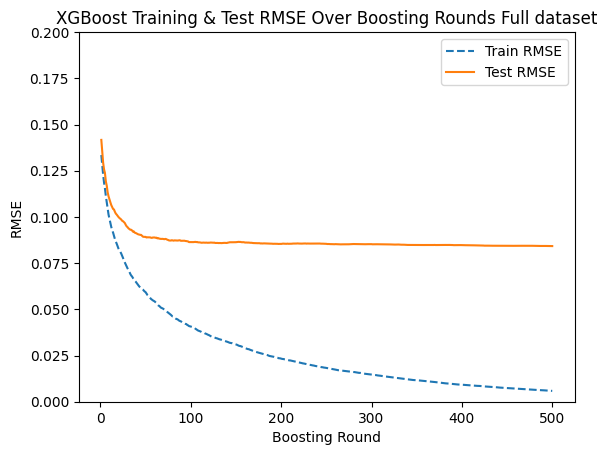

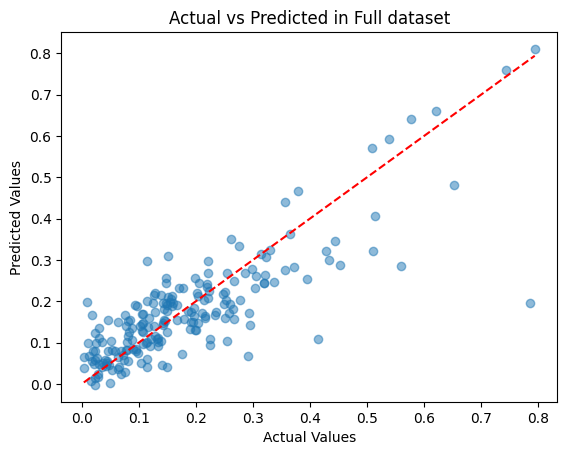

In [13]:
# #predict for the whole dataset (without rows having missing values on Grain.As)

# X , y = cleaned_dataset.iloc[: , [1, 2] + list(range(5, cleaned_dataset.shape[1]))] , cleaned_dataset.iloc[: , 4]
# train_X , test_X , train_y ,  test_y = train_test_split(X , y , test_size = 0.3 , random_state= 123)
# train_dmatrix = xg.DMatrix(data = train_X , label = train_y , missing = np.nan)
# test_dmatrix = xg.DMatrix(data = test_X , label = test_y, missing = np.nan)



# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'max_depth': 3,
#     'eta': 0.1,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'seed': 42
# }

# evals_result = {}

# full_model = xg.train(
#     params, 
#     train_dmatrix, 
#     num_boost_round=500, 
#     evals=[(train_dmatrix, 'train'), (test_dmatrix, 'test')],  # Log training and test RMSE
#     evals_result=evals_result,  
#     verbose_eval=True  
# )


# # Extract RMSE values
# train_rmse = evals_result['train']['rmse']
# test_rmse = evals_result['test']['rmse']

# # Plot both Training and Test RMSE
# plt.plot(range(1, len(train_rmse) + 1), train_rmse, label="Train RMSE", linestyle="--")
# plt.plot(range(1, len(test_rmse) + 1), test_rmse, label="Test RMSE")
# plt.xlabel("Boosting Round")
# plt.ylabel("RMSE")
# plt.ylim(0, 0.2)
# plt.title("XGBoost Training & Test RMSE Over Boosting Rounds")
# plt.legend()
# plt.show()

# # xgb_r = xg.train(params = params, dtrain = train_dmatrix, num_boost_round = 10) 
# pred = full_model.predict(test_dmatrix) 
  
# # RMSE Computation 
# rmse = np.sqrt(MSE(test_y, pred)) 
# print(f"RMSE {min(test_rmse )}") 


# type(test_y)
# result = pd.DataFrame(test_y)
# result['predict'] = pred

# result['difference_percent'] = abs(result['Grain.As'] - result['predict'])/result['Grain.As']*100

# y_true = result['Grain.As']



dataname = "Full dataset"

model1 , evals_result , test_X , test_y = training(cleaned_dataset , params , num_boost_round )

plot_training_curve(evals_result , dataname)

plot_prediction(model1 , test_X , test_y , dataname)

In [14]:
# import matplotlib.pyplot as plt 


In [15]:
# y_true = result['Grain.As']


# plt.scatter(result['Grain.As'], result['predict'], alpha=0.5)
# plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
# plt.xlabel("Actual Values")
# plt.ylabel("Predicted Values")
# plt.title("Actual vs Predicted in Full dataset")
# plt.show()

# Split the whole data set into different datasets for different crops

I suspect that the techniques to grow fields is different between crops, which can affects on the quality and chemical accumulation in grain/straw/soil. 
So I split dataset into: Winter-Spring season and Summer-Autumn season. This technique will further decrease RMSE on Asen cummulation prediction.

In [16]:
print(cleaned_dataset[cleaned_dataset['Season.planted'] == 'Winter-Spring season']['Grain.As'].mean() , cleaned_dataset[cleaned_dataset['Season.planted'] == 'Winter-Spring season']['Grain.As'].var() )
print(cleaned_dataset[cleaned_dataset['Season.planted'] == 'Summer-Autumn season']['Grain.As'].mean() , cleaned_dataset[cleaned_dataset['Season.planted'] == 'Summer-Autumn season']['Grain.As'].var())
WS_data = cleaned_dataset[cleaned_dataset['Season.planted'] == 'Winter-Spring season']

SA_data = cleaned_dataset[cleaned_dataset['Season.planted'] == 'Summer-Autumn season']

print(len(WS_data) , len(SA_data))

0.1532057502569244 0.009963997971955251
0.2143124887974399 0.041588421344006095
468 201


# Predict with Winter spring crops 

[0]	train-rmse:0.09192	test-rmse:0.10793
[1]	train-rmse:0.08900	test-rmse:0.10604
[2]	train-rmse:0.08627	test-rmse:0.10550
[3]	train-rmse:0.08402	test-rmse:0.10372
[4]	train-rmse:0.08176	test-rmse:0.10274
[5]	train-rmse:0.07969	test-rmse:0.10143
[6]	train-rmse:0.07798	test-rmse:0.10049
[7]	train-rmse:0.07621	test-rmse:0.09940
[8]	train-rmse:0.07468	test-rmse:0.09855
[9]	train-rmse:0.07284	test-rmse:0.09807
[10]	train-rmse:0.07141	test-rmse:0.09706
[11]	train-rmse:0.06985	test-rmse:0.09632
[12]	train-rmse:0.06862	test-rmse:0.09610
[13]	train-rmse:0.06729	test-rmse:0.09535
[14]	train-rmse:0.06580	test-rmse:0.09438
[15]	train-rmse:0.06461	test-rmse:0.09344
[16]	train-rmse:0.06377	test-rmse:0.09334
[17]	train-rmse:0.06260	test-rmse:0.09299
[18]	train-rmse:0.06162	test-rmse:0.09234
[19]	train-rmse:0.06049	test-rmse:0.09109
[20]	train-rmse:0.05949	test-rmse:0.09077
[21]	train-rmse:0.05874	test-rmse:0.09055
[22]	train-rmse:0.05768	test-rmse:0.08977
[23]	train-rmse:0.05673	test-rmse:0.08954
[2

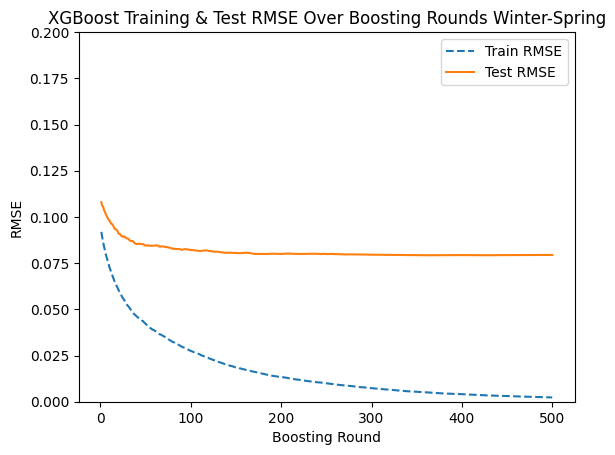

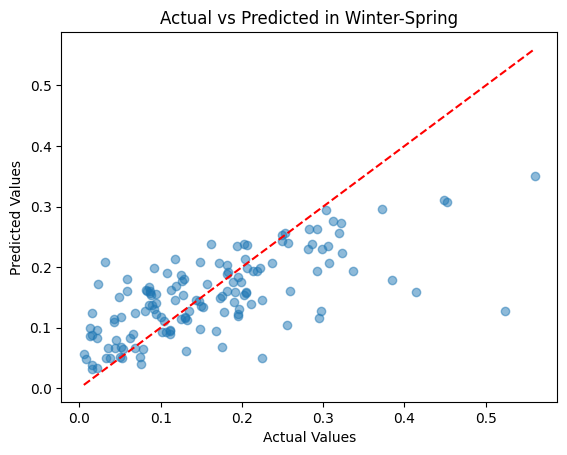

In [17]:
# #predicting for winter spring crops

# X , y = WS_data.iloc[: , [1, 2] + list(range(5, cleaned_dataset.shape[1]))] , WS_data.iloc[: , 4]

# train_X , test_X , train_y ,  test_y = train_test_split(X , y , test_size = 0.3 , random_state= 123)

# train_dmatrix = xg.DMatrix(data = train_X , label = train_y , missing = np.nan)
# test_dmatrix = xg.DMatrix(data = test_X , label = test_y, missing = np.nan)



# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'max_depth': 3,
#     'eta': 0.1,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'seed': 42
# }

# WS_model = xg.train(
#     params, 
#     train_dmatrix, 
#     num_boost_round=500, 
#     evals=[(train_dmatrix, 'train'), (test_dmatrix, 'test')],  # Log training and test RMSE
#     evals_result=evals_result,  
#     verbose_eval=True  
# )

# # Extract RMSE values
# train_rmse = evals_result['train']['rmse']
# test_rmse = evals_result['test']['rmse']
# # Plot both Training and Test RMSE
# plt.plot(range(1, len(train_rmse) + 1), train_rmse, label="Train RMSE", linestyle="--")
# plt.plot(range(1, len(test_rmse) + 1), test_rmse, label="Test RMSE")
# plt.xlabel("Boosting Round")
# plt.ylabel("RMSE")
# plt.ylim(0, 0.2)
# plt.title("XGBoost Training & Test RMSE Over Boosting Rounds")
# plt.legend()
# plt.show()
# pred = WS_model.predict(test_dmatrix) 
# # RMSE Computation 
# rmse = np.sqrt(MSE(test_y, pred)) 
# print(f"RMSE : {min(test_rmse)}") 


# type(test_y)
# result = pd.DataFrame(test_y)
# result['predict'] = pred

# y_true = result['Grain.As']

# plt.scatter(result['Grain.As'], result['predict'], alpha=0.5)
# plt.plot([-0.05, 0.85], [-0.05, 0.85], color='red', linestyle='--')
# plt.xlim(-0.05, 0.85)
# plt.ylim(-0.05, 0.85)
# plt.xlabel("Actual Values")
# plt.ylabel("Predicted Values")
# plt.title("Actual vs Predicted - Winter-Spring crops")
# plt.show()
dataname = "Winter-Spring"

model1 , evals_result , test_X , test_y = training(WS_data , params , num_boost_round )

plot_training_curve(evals_result , dataname)

plot_prediction(model1 , test_X , test_y ,  dataname)


# Predict for summer-autumn crops

[0]	train-rmse:0.19493	test-rmse:0.17753
[1]	train-rmse:0.18235	test-rmse:0.16784
[2]	train-rmse:0.17128	test-rmse:0.16022
[3]	train-rmse:0.16045	test-rmse:0.14887
[4]	train-rmse:0.15022	test-rmse:0.14082
[5]	train-rmse:0.14098	test-rmse:0.13418
[6]	train-rmse:0.13304	test-rmse:0.12844
[7]	train-rmse:0.12599	test-rmse:0.12230
[8]	train-rmse:0.11936	test-rmse:0.11474
[9]	train-rmse:0.11397	test-rmse:0.11041
[10]	train-rmse:0.10963	test-rmse:0.10871
[11]	train-rmse:0.10411	test-rmse:0.10671
[12]	train-rmse:0.09913	test-rmse:0.10403
[13]	train-rmse:0.09480	test-rmse:0.10108
[14]	train-rmse:0.09131	test-rmse:0.09951
[15]	train-rmse:0.08752	test-rmse:0.09891
[16]	train-rmse:0.08408	test-rmse:0.09629


[17]	train-rmse:0.08099	test-rmse:0.09438
[18]	train-rmse:0.07785	test-rmse:0.09196
[19]	train-rmse:0.07576	test-rmse:0.09139
[20]	train-rmse:0.07403	test-rmse:0.09012
[21]	train-rmse:0.07220	test-rmse:0.09003
[22]	train-rmse:0.07050	test-rmse:0.08944
[23]	train-rmse:0.06830	test-rmse:0.08855
[24]	train-rmse:0.06605	test-rmse:0.08758
[25]	train-rmse:0.06484	test-rmse:0.08706
[26]	train-rmse:0.06262	test-rmse:0.08621
[27]	train-rmse:0.06025	test-rmse:0.08572
[28]	train-rmse:0.05920	test-rmse:0.08570
[29]	train-rmse:0.05762	test-rmse:0.08545
[30]	train-rmse:0.05595	test-rmse:0.08517
[31]	train-rmse:0.05458	test-rmse:0.08532
[32]	train-rmse:0.05329	test-rmse:0.08578
[33]	train-rmse:0.05227	test-rmse:0.08560
[34]	train-rmse:0.05092	test-rmse:0.08477
[35]	train-rmse:0.04963	test-rmse:0.08431
[36]	train-rmse:0.04855	test-rmse:0.08408
[37]	train-rmse:0.04723	test-rmse:0.08361
[38]	train-rmse:0.04608	test-rmse:0.08322
[39]	train-rmse:0.04524	test-rmse:0.08336
[40]	train-rmse:0.04395	test-rmse:

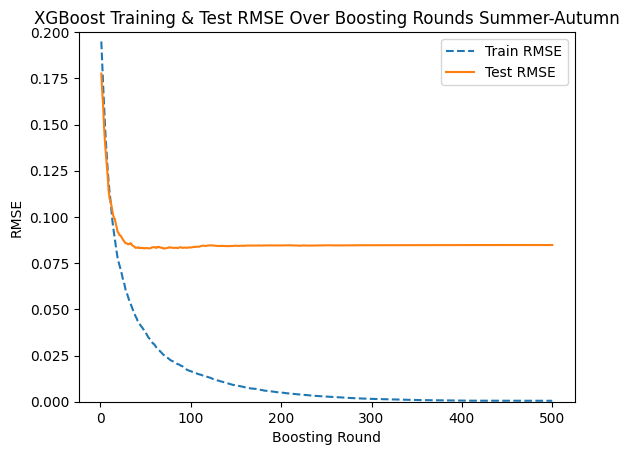

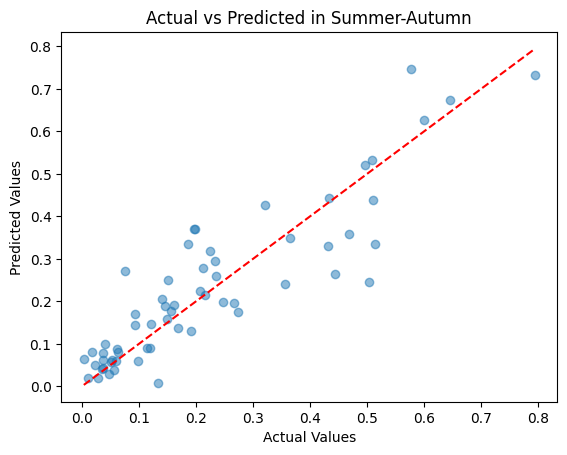

In [18]:
# #predicting for summer_autumn crops

# X , y = SA_data.iloc[: , [1, 2] + list(range(5, cleaned_dataset.shape[1]))] , SA_data.iloc[: , 4]

# train_X , test_X , train_y ,  test_y = train_test_split(X , y , test_size = 0.3 , random_state= 123)

# train_dmatrix = xg.DMatrix(data = train_X , label = train_y , missing = np.nan)
# test_dmatrix = xg.DMatrix(data = test_X , label = test_y, missing = np.nan)



# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'max_depth': 3,
#     'eta': 0.1,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'seed': 42
# }

# evals_result = {}
# # Train the model and log RMSE values

# # Train the model and log RMSE values for both training and test sets
# SA_model = xg.train(
#     params, 
#     train_dmatrix, 
#     num_boost_round=500, 
#     evals=[(train_dmatrix, 'train'), (test_dmatrix, 'test')],  # Log training and test RMSE
#     evals_result=evals_result,  
#     verbose_eval=True  
# )
# # Extract RMSE values
# train_rmse = evals_result['train']['rmse']
# test_rmse = evals_result['test']['rmse']

# # Plot both Training and Test RMSE
# plt.plot(range(1, len(train_rmse) + 1), train_rmse, label="Train RMSE", linestyle="--")
# plt.plot(range(1, len(test_rmse) + 1), test_rmse, label="Test RMSE")
# plt.xlabel("Boosting Round")
# plt.ylabel("RMSE")
# plt.ylim(0, 0.2)
# plt.title("XGBoost Training & Test RMSE Over Boosting Rounds")
# plt.legend()
# plt.show()




# pred = SA_model.predict(test_dmatrix) 
  
# # RMSE Computation 
# rmse = np.sqrt(MSE(test_y, pred)) 
# # print("RMSE : % f" %(rmse)) 
# print(f"RMSE {min(test_rmse)}")

# type(test_y)
# result = pd.DataFrame(test_y)
# result['predict'] = pred

# y_true = result['Grain.As']


# plt.scatter(result['Grain.As'], result['predict'], alpha=0.5)
# plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
# plt.xlabel("Actual Values")
# plt.ylabel("Predicted Values")
# plt.title("Actual vs Predicted - Summer-Autumn crop")
# plt.show()

dataname = "Summer-Autumn"

model1 , evals_result , test_X , test_y = training(SA_data , params , num_boost_round )

plot_training_curve(evals_result , dataname)

plot_prediction(model1 , test_X , test_y , dataname)




In [19]:
cleaned_dataset.iloc[:5 , :16]

,Sample.code,Lattitude,Longitude,Season.planted,Grain.As,Grain.P,Grain.S,Grain.Mn,Grain.Fe,Grain.Cu,Straw.As,Straw.Al,Straw.P,Straw.S,Straw.Mn,Straw.Fe
0,23Vin1_#1,10.105651,105.894707,Winter-Spring season,0.523334,2984.341641,1092.869532,22.782137,28.896448,2.074383,0.616872,627.615923,1151.179218,1612.474281,801.542633,401.254888
1,23Vin2_#1,10.071678,105.927982,Winter-Spring season,0.312485,3127.027761,1131.268467,19.842637,1.784861,2.024729,0.707296,249.273175,1136.949392,1376.276784,797.197832,217.919123
2,23Vin3_#1,10.073358,105.992213,Winter-Spring season,0.058160,3195.274467,991.132283,17.984741,41.951877,1.626614,0.526424,203.703811,1256.785962,1162.890087,263.397595,271.415308
3,23Vin4_#1,10.142449,106.021702,Winter-Spring season,0.037008,2682.304757,855.024208,16.678840,1.100623,1.760309,0.489382,382.900847,2626.530750,2375.451115,864.473531,356.117865
4,23Vin5_#1,10.075267,106.170488,Winter-Spring season,0.170522,2963.072168,810.699618,15.986882,3.180604,0.975245,4.031916,533.999448,1954.781134,738.888980,636.466670,493.523147


# Using location (lattitude and longtitude) for predicting Arsenic accumulation 

Because different areas have different climates, so farmer have to choose types of tree to grow. Different types of tree have different abilities of chemical accumulation 

### below experiment is taken earlier  


In [20]:
# #predict for the whole dataset (without rows having missing values on Grain.As)

# X , y = cleaned_dataset.iloc[:, [1, 2] + list(range(5, cleaned_dataset.shape[1]))], cleaned_dataset.iloc[:, 4]
# train_X , test_X , train_y ,  test_y = train_test_split(X , y , test_size = 0.3 , random_state= 123)
# train_dmatrix = xg.DMatrix(data = train_X , label = train_y , missing = np.nan)
# test_dmatrix = xg.DMatrix(data = test_X , label = test_y, missing = np.nan)





# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'max_depth': 3,
#     'eta': 0.1,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'seed': 42
# }

# model0 = xg.train(params, train_dmatrix, num_boost_round=1000, evals=[(test_dmatrix, 'test')])

# # xgb_r = xg.train(params = params, dtrain = train_dmatrix, num_boost_round = 10) 
# pred = model0.predict(test_dmatrix) 
  
# # RMSE Computation 
# rmse = np.sqrt(MSE(test_y, pred)) 
# print("RMSE : % f" %(rmse)) 


# type(test_y)
# result = pd.DataFrame(test_y)
# result['predict'] = pred

# result['difference_percent'] = abs(result['Grain.As'] - result['predict'])/result['Grain.As']*100

# y_true = result['Grain.As']



# plt.scatter(result['Grain.As'], result['predict'], alpha=0.5)
# plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
# plt.xlabel("Actual Values")
# plt.ylabel("Predicted Values")
# plt.title("Actual vs Predicted - Summer-Autumn crop")
# plt.show()





In [21]:
# #predict for the whole dataset (without rows having missing values on Grain.As)

# X , y = cleaned_dataset.iloc[:, [1, 2] + list(range(5, 16))], cleaned_dataset.iloc[:, 4]
# train_X , test_X , train_y ,  test_y = train_test_split(X , y , test_size = 0.3 , random_state= 123)
# train_dmatrix = xg.DMatrix(data = train_X , label = train_y , missing = np.nan)
# test_dmatrix = xg.DMatrix(data = test_X , label = test_y, missing = np.nan)



# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'max_depth': 3,
#     'eta': 0.1,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'seed': 42
# }

# model2 = xg.train(params, train_dmatrix, num_boost_round=1000, evals=[(test_dmatrix, 'test')])

# # xgb_r = xg.train(params = params, dtrain = train_dmatrix, num_boost_round = 10) 
# pred = model2.predict(test_dmatrix) 
  
# # RMSE Computation 
# rmse = np.sqrt(MSE(test_y, pred)) 
# print("RMSE : % f" %(rmse)) 


# type(test_y)
# result = pd.DataFrame(test_y)
# result['predict'] = pred

# result['difference_percent'] = abs(result['Grain.As'] - result['predict'])/result['Grain.As']*100

# y_true = result['Grain.As']




# type(test_y)
# result = pd.DataFrame(test_y)
# result['predict'] = pred

# y_true = result['Grain.As']


# plt.scatter(result['Grain.As'], result['predict'], alpha=0.5)
# plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
# plt.xlabel("Actual Values")
# plt.ylabel("Predicted Values")
# plt.title("Actual vs Predicted - Summer-Autumn crop")
# plt.show()





In [22]:
for i in range(len(cleaned_dataset.columns)):
    print(i , cleaned_dataset.columns[i])

0 Sample.code
1 Lattitude 
2 Longitude
3 Season.planted
4 Grain.As
5 Grain.P
6 Grain.S
7 Grain.Mn
8 Grain.Fe
9 Grain.Cu
10 Straw.As
11 Straw.Al
12 Straw.P
13 Straw.S
14 Straw.Mn
15 Straw.Fe
16 Soil.As
17 Soil.Al
18 Soil.P
19 Soil.S
20 Soil.Mn
21 Soil.Fe
22 Soil.pH
23 Soil.Clay
24 Soil.SOM
25 Temperature
26 Rainfall
27 Humidity
28 Potential.Evaporation


### below is experiment not using location

In [23]:
# #predict for the whole dataset (without rows having missing values on Grain.As)



# X , y = cleaned_dataset.iloc[: , 5:], cleaned_dataset.iloc[:, 4]
# train_X , test_X , train_y ,  test_y = train_test_split(X , y , test_size = 0.3 , random_state= 123)
# train_dmatrix = xg.DMatrix(data = train_X , label = train_y , missing = np.nan)
# test_dmatrix = xg.DMatrix(data = test_X , label = test_y, missing = np.nan)



# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'max_depth': 3,
#     'eta': 0.1,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'seed': 42
# }

# model3 = xg.train(params, train_dmatrix, num_boost_round=1000, evals=[(test_dmatrix, 'test')])

# # xgb_r = xg.train(params = params, dtrain = train_dmatrix, num_boost_round = 10) 
# pred = model3.predict(test_dmatrix) 
  
# # RMSE Computation 
# rmse = np.sqrt(MSE(test_y, pred)) 
# print("RMSE : % f" %(rmse)) 


# type(test_y)
# result = pd.DataFrame(test_y)
# result['predict'] = pred

# result['difference_percent'] = abs(result['Grain.As'] - result['predict'])/result['Grain.As']*100

# y_true = result['Grain.As']




# type(test_y)
# result = pd.DataFrame(test_y)
# result['predict'] = pred

# y_true = result['Grain.As']


# plt.scatter(result['Grain.As'], result['predict'], alpha=0.5)
# plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
# plt.xlabel("Actual Values")
# plt.ylabel("Predicted Values")
# plt.title("Actual vs Predicted - Summer-Autumn crop")
# plt.show()





In [24]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

### below are encoding Season to a feature and then use it for XGboost in full dataset

In [25]:
# df_clean = cleaned_dataset

# # Encode categorical features
# label_encoder = LabelEncoder()
# df_clean['Season.planted'] = label_encoder.fit_transform(df_clean['Season.planted'])

# # Separate features and target variable
# x_cat = df_clean[['Season.planted']]
# x_num = df_clean.drop(columns=['Season.planted' , 'Sample.code' , 'Grain.As']).values
# X = pd.concat([pd.DataFrame(x_num), x_cat.reset_index(drop=True)], axis=1).values
# y = df_clean.iloc[: , 4]


# train_X , test_X , train_y ,  test_y = train_test_split(X , y , test_size = 0.3 , random_state= 123)
# train_dmatrix = xg.DMatrix(data = train_X , label = train_y , missing = np.nan)
# test_dmatrix = xg.DMatrix(data = test_X , label = test_y, missing = np.nan)




# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'max_depth': 3,
#     'eta': 0.1,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'seed': 42
# }



# type(test_y)
# result = pd.DataFrame(test_y)
# result['predict'] = pred

# result['difference_percent'] = abs(result['Grain.As'] - result['predict'])/result['Grain.As']*100

# y_true = result['Grain.As']




# type(test_y)
# result = pd.DataFrame(test_y)
# result['predict'] = pred

# y_true = result['Grain.As']


# plt.scatter(result['Grain.As'], result['predict'], alpha=0.5)
# plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
# plt.xlabel("Actual Values")
# plt.ylabel("Predicted Values")
# plt.title("Actual vs Predicted - Summer-Autumn crop")
# plt.show()





### below are experiment only using high correlated values with Grain Asen

In [26]:
# #predict for the whole dataset (without rows having missing values on Grain.As)

# X , y = cleaned_dataset.iloc[: , [1,2,5,6,7,8,12,13]], cleaned_dataset.iloc[: , 4]
# train_X , test_X , train_y ,  test_y = train_test_split(X , y , test_size = 0.3 , random_state= 123)
# train_dmatrix = xg.DMatrix(data = train_X , label = train_y , missing = np.nan)
# test_dmatrix = xg.DMatrix(data = test_X , label = test_y, missing = np.nan)



# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'max_depth': 3,
#     'eta': 0.1,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'seed': 42
# }

# evals_result = {}


# model_of_high_correlated = xg.train(
#     params, 
#     train_dmatrix, 
#     num_boost_round=500, 
#     evals=[(train_dmatrix, 'train'), (test_dmatrix, 'test')],  # Log training and test RMSE
#     evals_result=evals_result,  
#     verbose_eval=True  
# )


# # Extract RMSE values
# train_rmse = evals_result['train']['rmse']
# test_rmse = evals_result['test']['rmse']

# # Plot both Training and Test RMSE
# plt.plot(range(1, len(train_rmse) + 1), train_rmse, label="Train RMSE", linestyle="--")
# plt.plot(range(1, len(test_rmse) + 1), test_rmse, label="Test RMSE")
# plt.xlabel("Boosting Round")
# plt.ylabel("RMSE")
# plt.ylim(0, 0.2)
# plt.title("XGBoost Training & Test RMSE Over Boosting Rounds")
# plt.legend()
# plt.show()

# # xgb_r = xg.train(params = params, dtrain = train_dmatrix, num_boost_round = 10) 
# pred = model_of_high_correlated.predict(test_dmatrix) 
  
# # RMSE Computation 
# rmse = np.sqrt(MSE(test_y, pred)) 
# print(f"RMSE {min(test_rmse )}") 


# type(test_y)
# result = pd.DataFrame(test_y)
# result['predict'] = pred

# result['difference_percent'] = abs(result['Grain.As'] - result['predict'])/result['Grain.As']*100

# y_true = result['Grain.As']




# Using KFold to evaluate as if location is truely neccessary 

In [27]:
# def run_kfold(params , dataset, dataname,  location = True , cv = 5, plot_result = False):
#     kfold = KFold(cv , shuffle = True , random_state=seed)

#     if location:
#         X , y = dataset.iloc[: , [1, 2] + list(range(5, dataset.shape[1]))] , dataset.iloc[: , 4]
#     else:
#         X , y = dataset.iloc[: ,list(range(5, dataset.shape[1]))] , dataset.iloc[: , 4]


#     test_rmse = []
#     for fold, (train_idx, test_idx) in enumerate(kfold.split(X)):
#         evals_result = {}
#         print(f"Training fold {fold+1}/{cv}")


        
#         train_X, test_X = X.iloc[train_idx] , X.iloc[test_idx]
#         train_y  , test_y = y.iloc[train_idx] , y.iloc[test_idx]

#         train_dmatrix = xg.DMatrix(data = train_X , label = train_y , missing = np.nan)
#         test_dmatrix = xg.DMatrix(data = test_X , label = test_y, missing = np.nan)
#         model = xg.train(params , train_dmatrix, 
#             num_boost_round=num_boost_round, 
#             evals=[(train_dmatrix, 'train'), (test_dmatrix, 'test')],  # Log training and test RMSE
#             evals_result=evals_result,  
#             verbose_eval=True )
        
#         min_test_rmse = min(evals_result['test']['rmse'])
#         test_rmse.append(min_test_rmse)

#         if plot_result == True and fold == cv-1:
#             plot_training_curve(evals_result , dataname)

#         print(f"Fold {fold + 1} RMSE: {min_test_rmse:.4f}\n")
#     return test_rmse



        




        



    

Training fold 1/5
[0]	train-rmse:0.13335	test-rmse:0.14436
[1]	train-rmse:0.12781	test-rmse:0.13873


[2]	train-rmse:0.12262	test-rmse:0.13278
[3]	train-rmse:0.11875	test-rmse:0.12892
[4]	train-rmse:0.11436	test-rmse:0.12506
[5]	train-rmse:0.11024	test-rmse:0.12151
[6]	train-rmse:0.10710	test-rmse:0.11954
[7]	train-rmse:0.10384	test-rmse:0.11725
[8]	train-rmse:0.10074	test-rmse:0.11553
[9]	train-rmse:0.09813	test-rmse:0.11387
[10]	train-rmse:0.09576	test-rmse:0.11260
[11]	train-rmse:0.09370	test-rmse:0.11151
[12]	train-rmse:0.09217	test-rmse:0.11104
[13]	train-rmse:0.09058	test-rmse:0.11037
[14]	train-rmse:0.08918	test-rmse:0.11001
[15]	train-rmse:0.08792	test-rmse:0.10962
[16]	train-rmse:0.08666	test-rmse:0.10900
[17]	train-rmse:0.08530	test-rmse:0.10798
[18]	train-rmse:0.08392	test-rmse:0.10787
[19]	train-rmse:0.08265	test-rmse:0.10750
[20]	train-rmse:0.08151	test-rmse:0.10735
[21]	train-rmse:0.08083	test-rmse:0.10771
[22]	train-rmse:0.08010	test-rmse:0.10788
[23]	train-rmse:0.07884	test-rmse:0.10758
[24]	train-rmse:0.07749	test-rmse:0.10699
[25]	train-rmse:0.07648	test-rmse:0.10638


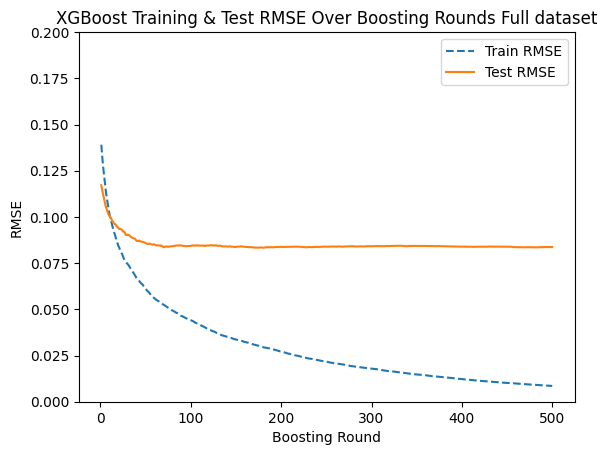

Fold 5 RMSE: 0.0833

Training fold 1/5
[0]	train-rmse:0.13467	test-rmse:0.14542
[1]	train-rmse:0.12853	test-rmse:0.13943
[2]	train-rmse:0.12415	test-rmse:0.13769
[3]	train-rmse:0.11933	test-rmse:0.13271
[4]	train-rmse:0.11506	test-rmse:0.12862
[5]	train-rmse:0.11108	test-rmse:0.12475
[6]	train-rmse:0.10729	test-rmse:0.12105
[7]	train-rmse:0.10444	test-rmse:0.11902
[8]	train-rmse:0.10174	test-rmse:0.11625
[9]	train-rmse:0.09917	test-rmse:0.11469
[10]	train-rmse:0.09665	test-rmse:0.11255
[11]	train-rmse:0.09445	test-rmse:0.11089
[12]	train-rmse:0.09299	test-rmse:0.11021
[13]	train-rmse:0.09155	test-rmse:0.10952
[14]	train-rmse:0.09024	test-rmse:0.10872
[15]	train-rmse:0.08901	test-rmse:0.10817
[16]	train-rmse:0.08777	test-rmse:0.10783
[17]	train-rmse:0.08619	test-rmse:0.10704
[18]	train-rmse:0.08518	test-rmse:0.10588
[19]	train-rmse:0.08377	test-rmse:0.10586
[20]	train-rmse:0.08252	test-rmse:0.10555
[21]	train-rmse:0.08115	test-rmse:0.10454
[22]	train-rmse:0.07976	test-rmse:0.10410
[23]	

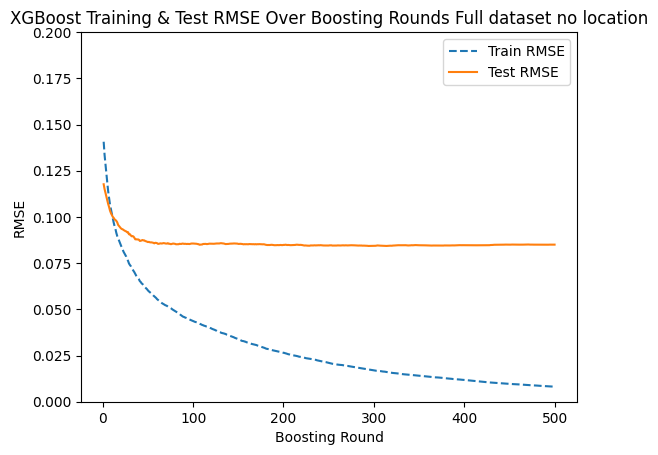

Fold 5 RMSE: 0.0843



In [28]:
# For full dataset 

test_rmse_with_location = run_kfold(params , cleaned_dataset , "Full dataset" , location=True , cv=5, plot_result= True)

test_rmse_without_location = run_kfold(params , cleaned_dataset , "Full dataset no location" , location=False , cv = 5, plot_result= True)





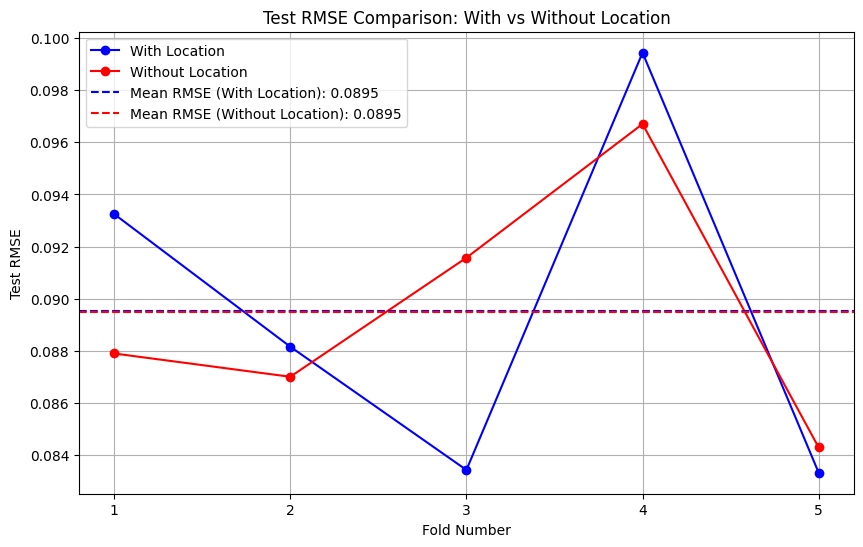

In [29]:




# Number of folds
num_folds = len(test_rmse_with_location)

# Create x-axis values (fold numbers)
folds = np.arange(1, num_folds + 1)

# Calculate mean RMSE for both scenarios
mean_rmse_with_location = np.mean(test_rmse_with_location)
mean_rmse_without_location = np.mean(test_rmse_without_location)

# Plotting
plt.figure(figsize=(10, 6))

# Plot RMSE for each fold
plt.plot(folds, test_rmse_with_location, marker='o', label='With Location', color='blue')
plt.plot(folds, test_rmse_without_location, marker='o', label='Without Location', color='red')

# Plot mean RMSE lines
plt.axhline(mean_rmse_with_location, color='blue', linestyle='--', label=f'Mean RMSE (With Location): {mean_rmse_with_location:.4f}')
plt.axhline(mean_rmse_without_location, color='red', linestyle='--', label=f'Mean RMSE (Without Location): {mean_rmse_without_location:.4f}')

# Add labels and title
plt.xlabel('Fold Number')
plt.ylabel('Test RMSE')
plt.title('Test RMSE Comparison: With vs Without Location')
plt.xticks(folds)  # Ensure x-axis shows fold numbers
plt.legend()
plt.grid(True)

# Show plot
plt.show()